# Modelo simple

# Modelo de Machine Learning para clasificar si una persona puede tener COVID-19 con variables de comorbilidades 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Importando el Data Frame

In [2]:
df = pd.read_csv("210127COVID19MEXICO.csv", 
                 usecols = [2,3,4,5,6,9,10,11,12,13,14,15,16,17,19,20,21,22,23,24,
                                                       25,26,27,28,29,30,31,32,33,34,35,36,37,39], 
                 encoding='latin1',
                 dtype = {"FECHA_SINTOMAS":"str"})
df.head()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,FECHA_DEF,INTUBADO,...,TABAQUISMO,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,UCI
0,2,12,9,2,9,1,2020-03-11,2020-03-11,9999-99-99,97,...,2,1,1,1,2,97,3,99,MÃ©xico,97
1,1,12,17,2,17,2,2020-03-28,2020-03-24,2020-04-10,2,...,2,2,1,1,2,97,3,99,MÃ©xico,2
2,1,4,23,2,23,1,2020-03-30,2020-03-28,9999-99-99,97,...,2,1,1,1,2,97,3,99,MÃ©xico,97
3,1,9,9,2,9,2,2020-03-28,2020-03-25,9999-99-99,2,...,2,1,1,1,2,97,3,99,MÃ©xico,2
4,1,12,29,2,29,2,2020-04-01,2020-03-28,9999-99-99,2,...,2,2,1,1,2,97,3,99,MÃ©xico,2


# Limpiza de datos

### Se cambian los tipode de las variables de objeto a fecha

Existen variables que tienen el Dtype no correspondiente 

In [3]:
df["FECHA_INGRESO"] = df["FECHA_INGRESO"].apply(lambda x: x.replace('-',''))
df["FECHA_DEF"] = df["FECHA_DEF"].apply(lambda x: x.replace('-',''))
df["FECHA_SINTOMAS"] = df["FECHA_SINTOMAS"].apply(lambda x: x.replace('-',''))

In [4]:
df["FECHA_INGRESO"] = pd.to_datetime(df["FECHA_INGRESO"], format = '%Y%m%d')
df["FECHA_SINTOMAS"] = pd.to_datetime(df["FECHA_SINTOMAS"], format = '%Y%m%d')

In [5]:
df = df.drop(["ENTIDAD_UM","ENTIDAD_NAC", "FECHA_INGRESO","FECHA_SINTOMAS","INDIGENA","TOMA_MUESTRA_LAB",
        "RESULTADO_LAB","TOMA_MUESTRA_ANTIGENO","RESULTADO_ANTIGENO","MIGRANTE","PAIS_NACIONALIDAD","OTRO_CASO"], axis = 1)

##### Eliminacion de las primeras variables
1.- Se eliminan todas las variables respecto a fechas ya que supondremos observaciones independientes al tiempo \
2.- Se eliminan la entidad médica ya que no nos interesa la proveniencia de la muestra solo de los resultados \
3.- Se eliminan cualquier entidad racial, nos enfocamos en todos los pacientes de origen Mexicano \
4.- Se eliminan la entidad donde se tomó la muestra para cualquier prueba, por ahora solo nos interesan los resultados \
5.- Se eliminan los paises de origen ya que existe una variable que es dependiente a ellas y que sirve más para el estudio 

## Verificar tipos de datos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4544322 entries, 0 to 4544321
Data columns (total 22 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   ORIGEN               int64 
 1   SECTOR               int64 
 2   SEXO                 int64 
 3   TIPO_PACIENTE        int64 
 4   FECHA_DEF            object
 5   INTUBADO             int64 
 6   NEUMONIA             int64 
 7   EDAD                 int64 
 8   NACIONALIDAD         int64 
 9   EMBARAZO             int64 
 10  DIABETES             int64 
 11  EPOC                 int64 
 12  ASMA                 int64 
 13  INMUSUPR             int64 
 14  HIPERTENSION         int64 
 15  OTRA_COM             int64 
 16  CARDIOVASCULAR       int64 
 17  OBESIDAD             int64 
 18  RENAL_CRONICA        int64 
 19  TABAQUISMO           int64 
 20  CLASIFICACION_FINAL  int64 
 21  UCI                  int64 
dtypes: int64(21), object(1)
memory usage: 762.7+ MB


## Creacion de nuevas variables

### Para la variable objetivo

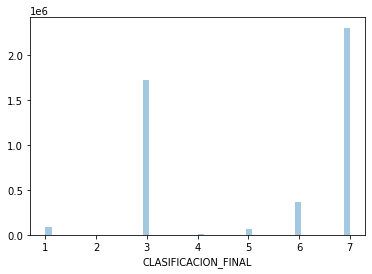

In [7]:
sns.distplot(df["CLASIFICACION_FINAL"], kde = False);

Eliminar los registros donde los pacientes aun son sospechosos ya que nos generan información para la clasificación de los pacientes que tuvieron o no covid. \
Los registros donde se tomaron muestra de laboratorio pero fueron invalidos o no se procesó tampoco nos interesan para este caso de estudio

In [8]:
df = df.drop(df[df["CLASIFICACION_FINAL"].isin([4,5,6])].index, axis = 0)

Ya que necesitamos una variable objetivo donde catalogué a una persona con COVID o no, generamos una categoria nueva con base a la CLASIFICACION_FINAL donde muestra los tipos de resultados pero especificado por casos. Al final tendremos una nueva clasficación: 
* 1,2 y 3 se catalogan como paciente COVID
* 7 se catalogan como paciente NO COVID

Con esta información se crea la variable COVID

In [9]:
COV = []
for y in df["CLASIFICACION_FINAL"]:
    if (y == 1) or (y == 2) or (y == 3):
        k = 1
    else:
        k = 0
    COV.append(k)

In [10]:
df["COVID"] = COV

##### Personas diagnosticadas con COVID

In [11]:
pd.DataFrame(df["COVID"].value_counts())

,COVID
0,2305274
1,1806849


### Para la variable defunciones

Creamos una nueva variable que nos indique si el paciente falleció o no.

In [12]:
df["FECHA_DEF"] = df["FECHA_DEF"].astype("int")

In [13]:
DEF = []
for x in df["FECHA_DEF"]:
    if x == 99999999:
        j = 0
    else:
        j = 1
    DEF.append(j)

In [14]:
df["DEF"] = DEF
#df_copy = df_copy.drop(["FECHA_DEF"], axis = 1)

### Para la variable nacionalidad

Nos quedamos con los pacientes que sean de nacionalidad Mexicana 

In [15]:
df = df.drop(df[df["NACIONALIDAD"] == 2].index, axis = 0)

In [16]:
df = df.drop(["FECHA_DEF", "CLASIFICACION_FINAL"], axis = 1)

# Entendimiento de los datos 

##### La distribucion de las edades de pacientes con COVID nos muestran que existe una mayor concentracion de población con edades de entre 25 y 50 años

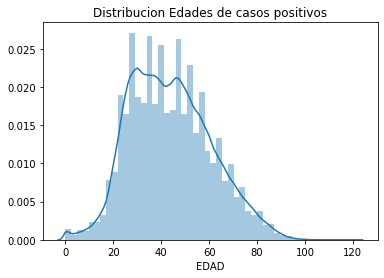

In [17]:
sns.distplot(df["EDAD"][df["COVID"] == 1])
plt.title("Distribucion Edades de casos positivos");

###### La distribución de edades de personas que no tienen COVID nos muestra una baja de diagnositicos a partir de los 30 años. Esto quiere decir que a mayor edad es más probable que no te diagnostiquen con NO COVID. Y a menor edad es más probable que te diagnostiquen con NO COVID.

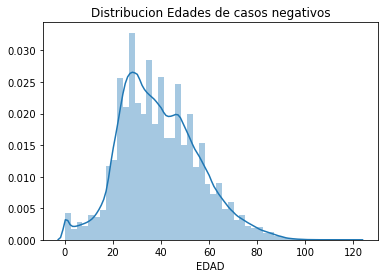

In [18]:
sns.distplot(df["EDAD"][df["COVID"] == 0])
plt.title("Distribucion Edades de casos negativos");

##### La distribucion de edad de personas que NO tienen COVID pero se compara con las personas fallecidas. Es decir, nos muestran la proporción de personas que si fallecieron contras los que no han fallecido. Esto nos puede señalar que en caso de diagnostico NO COVID es poco probable  la defunción.

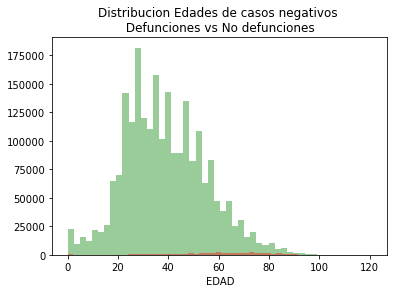

In [19]:
sns.distplot(df["EDAD"][(df["COVID"] == 0) & (df["DEF"] == 0)], color = "green", kde = False)
sns.distplot(df["EDAD"][(df["COVID"] == 0) & (df["DEF"] == 1)], color = "red", kde = False)
plt.title("Distribucion Edades de casos negativos \n Defunciones vs No defunciones ");

##### La distribucion de edad de personas que tienen COVID pero se compara con las personas fallecidas. En comparación con la grafica anterior es evidente que existe una mayor proporcion de defunciones cuando se diagnostica COVID. Es decir, existe una mayor probabilidad de defunción cuando se diagnostica con COVID.

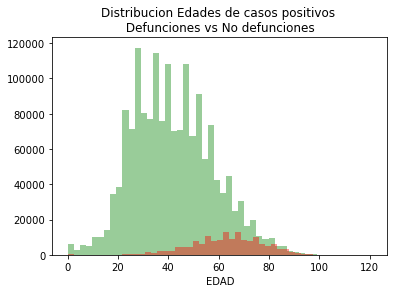

In [20]:
sns.distplot(df["EDAD"][(df["COVID"] == 1) & (df["DEF"] == 0)], color = "green", kde = False)
sns.distplot(df["EDAD"][(df["COVID"] == 1) & (df["DEF"] == 1)], color = "red", kde = False)
plt.title("Distribucion Edades de casos positivos \n Defunciones vs No defunciones ");

## Datos faltantes

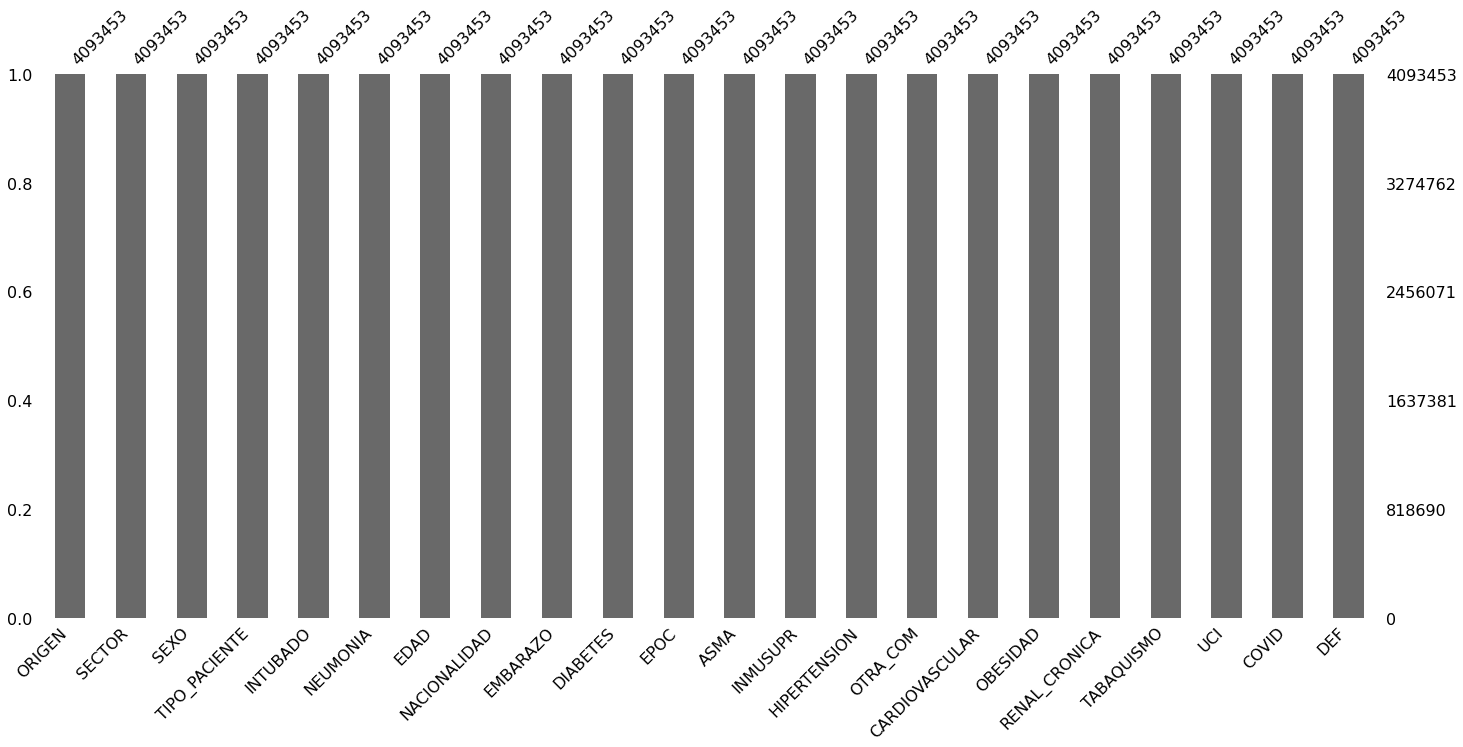

In [22]:
msno.bar(df)

No se encontró ninugun dato faltante, todos estan completos

In [23]:
print("El tamaño del DataFrame:", df.shape)

El tamaño del DataFrame: (4093453, 22)


# Tratamiento de variables

### Valores de las variables 

In [24]:
for i in df:
    if (i == "FECHA_DEF") or (i == "EDAD") or (i == "SEXO") or (i == "NACIONALIDAD"):
        continue
    print("Los valores unicos de",i,"son: ",df[i].unique())

Los valores unicos de ORIGEN son:  [2 1]
Los valores unicos de SECTOR son:  [12  4  9  6  3 13  8 11 10  5  7  2  1 99]
Los valores unicos de TIPO_PACIENTE son:  [1 2]
Los valores unicos de INTUBADO son:  [97  2  1 99]
Los valores unicos de NEUMONIA son:  [ 2  1 99]
Los valores unicos de EMBARAZO son:  [97  2  1 98 99]
Los valores unicos de DIABETES son:  [ 2  1 98]
Los valores unicos de EPOC son:  [ 2  1 98]
Los valores unicos de ASMA son:  [ 2  1 98]
Los valores unicos de INMUSUPR son:  [ 2  1 98]
Los valores unicos de HIPERTENSION son:  [ 1  2 98]
Los valores unicos de OTRA_COM son:  [ 2  1 98]
Los valores unicos de CARDIOVASCULAR son:  [ 2  1 98]
Los valores unicos de OBESIDAD son:  [ 1  2 98]
Los valores unicos de RENAL_CRONICA son:  [ 2  1 98]
Los valores unicos de TABAQUISMO son:  [ 2  1 98]
Los valores unicos de UCI son:  [97  2  1 99]
Los valores unicos de COVID son:  [1 0]
Los valores unicos de DEF son:  [0 1]


### Revisamos los valores NA's de los datos. En este caso se especifican como 97,98 y 99 para referirse a un dato que no aplica, se ignora o no se especifica respectivamente

In [25]:
x = []
for i in df:
    if (i == "FECHA_DEF") or (i == "EDAD") or (i == "SEXO") or (i == "NACIONALIDAD") or (i == "SECTOR"):
        continue
    x.append(df[i].value_counts())

#### Valores 99

In [26]:
N = df.shape[0]

for j in range(0,len(x)):
    for i in x[j].index:
        if i == 99:
            if x[j][99]/N < .1:
                print("Los valores 99 de",x[j].name,"son menores que 1% y es el",round((x[j][99]/N)*100,2),"% de los datos")
            else:
                print("** Los valores 99 de",x[j].name,"son mayores que 1% y es el :",round((x[j][99]/N)*100,2),"% de los datos")

Los valores 99 de INTUBADO son menores que 1% y es el 0.15 % de los datos
Los valores 99 de NEUMONIA son menores que 1% y es el 0.16 % de los datos
Los valores 99 de EMBARAZO son menores que 1% y es el 0.0 % de los datos
Los valores 99 de UCI son menores que 1% y es el 0.16 % de los datos


In [27]:
for j in range(0,len(x)):
    for i in x[j].index:
        if i == 99:
            if x[j][99]/N < .1:
                print("Los valores 99 de",x[j].name,"son menores a 1% y son", x[j][99])
            else:
                print("** Los valores 99 de",x[j].name," son mayores a 1% y son:",x[j][99])

Los valores 99 de INTUBADO son menores a 1% y son 6213
Los valores 99 de NEUMONIA son menores a 1% y son 6671
Los valores 99 de EMBARAZO son menores a 1% y son 3
Los valores 99 de UCI son menores a 1% y son 6576


#### Valores 98

In [28]:
for j in range(0,len(x)):
    for i in x[j].index:
        if i == 98:
            if x[j][98]/N < .1:
                print("Los valores 98 de",x[j].name,"Son menores al 1% y es el:",round((x[j][98]/N)*100,2),"% de los datos")
            else:
                print("** Los valores 98 de",x[j].name,"Son mayores al 1% y es el:",round((x[j][98]/N)*100,2),"% de los datos")

Los valores 98 de EMBARAZO Son menores al 1% y es el: 0.33 % de los datos
Los valores 98 de DIABETES Son menores al 1% y es el: 0.24 % de los datos
Los valores 98 de EPOC Son menores al 1% y es el: 0.22 % de los datos
Los valores 98 de ASMA Son menores al 1% y es el: 0.21 % de los datos
Los valores 98 de INMUSUPR Son menores al 1% y es el: 0.22 % de los datos
Los valores 98 de HIPERTENSION Son menores al 1% y es el: 0.22 % de los datos
Los valores 98 de OTRA_COM Son menores al 1% y es el: 0.36 % de los datos
Los valores 98 de CARDIOVASCULAR Son menores al 1% y es el: 0.22 % de los datos
Los valores 98 de OBESIDAD Son menores al 1% y es el: 0.21 % de los datos
Los valores 98 de RENAL_CRONICA Son menores al 1% y es el: 0.21 % de los datos
Los valores 98 de TABAQUISMO Son menores al 1% y es el: 0.23 % de los datos


In [29]:
for j in range(0,len(x)):
    for i in x[j].index:
        if i == 98:
            if x[j][98]/N < .1:
                print("Los valores 98 de",x[j].name,"Son menores a 1% y son", x[j][98])
            else:
                print("** Los valores 98 de",x[j].name,"Son mayores a 1% y son:", x[j][98])

Los valores 98 de EMBARAZO Son menores a 1% y son 13341
Los valores 98 de DIABETES Son menores a 1% y son 9809
Los valores 98 de EPOC Son menores a 1% y son 8902
Los valores 98 de ASMA Son menores a 1% y son 8708
Los valores 98 de INMUSUPR Son menores a 1% y son 9087
Los valores 98 de HIPERTENSION Son menores a 1% y son 8973
Los valores 98 de OTRA_COM Son menores a 1% y son 14535
Los valores 98 de CARDIOVASCULAR Son menores a 1% y son 8844
Los valores 98 de OBESIDAD Son menores a 1% y son 8429
Los valores 98 de RENAL_CRONICA Son menores a 1% y son 8739
Los valores 98 de TABAQUISMO Son menores a 1% y son 9274


#### Valores 97

In [30]:
for j in range(0,len(x)):
    for i in x[j].index:
        if i == 97:
            if x[j][97]/N < .1:
                print("Los valores 97 de",x[j].name," son menores a 1% y es el:", round((x[j][97]/N)*100,2),"% de los datos")
            else:
                print("** Los valores 97 de",x[j].name,"son mayores a 1% y es el:", round((x[j][97]/N)*100,2),"% de los datos")

** Los valores 97 de INTUBADO son mayores a 1% y es el: 87.32 % de los datos
** Los valores 97 de EMBARAZO son mayores a 1% y es el: 48.0 % de los datos
** Los valores 97 de UCI son mayores a 1% y es el: 87.32 % de los datos


In [31]:
for j in range(0,len(x)):
    for i in x[j].index:
        if i == 97:
            if x[j][97]/N < .1:
                print("Los valores 97 de",x[j].name," son menores a 1% y son:", x[j][97])
            else:
                print("** Los valores 97 de",x[j].name,"son mayores a 1% y son:", x[j][97],"datos")

** Los valores 97 de INTUBADO son mayores a 1% y son: 3574281 datos
** Los valores 97 de EMBARAZO son mayores a 1% y son: 1964713 datos
** Los valores 97 de UCI son mayores a 1% y son: 3574281 datos


# NA's, valores faltantes (97,98,99)

Las variables que más NA's tienen son: INTUBADO, EMBARAZO, UCI, NEUMONIA y OTRO_CASO. Resolveremos el problema de estas variables y sus valores para no eliminarlos. 

### Analizando la variable EMBARAZO

In [32]:
df[(df["EMBARAZO"] == 97) & (df["SEXO"] == 2)]

,ORIGEN,SECTOR,SEXO,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,DIABETES,...,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,UCI,COVID,DEF
0,2,12,2,1,97,2,73,1,97,2,...,2,1,2,2,1,2,2,97,1,0
1,1,12,2,2,2,1,59,1,97,1,...,2,2,2,2,2,2,2,2,1,1
2,1,4,2,1,97,2,42,1,97,2,...,2,2,2,2,2,2,2,97,1,0
3,1,9,2,2,2,1,70,1,97,2,...,2,1,2,2,2,2,2,2,1,0
4,1,12,2,2,2,1,62,1,97,2,...,2,2,2,2,2,2,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4544314,2,4,2,1,97,2,21,1,97,2,...,2,2,2,2,1,2,2,97,0,0
4544316,2,12,2,1,97,2,58,1,97,2,...,2,2,2,2,2,2,2,97,1,0
4544317,2,4,2,1,97,2,75,1,97,1,...,2,1,2,2,2,2,1,97,1,1
4544318,1,4,2,1,97,1,51,1,97,2,...,2,2,2,2,2,2,2,97,0,0


Los registros que tienen el valor 97, es decir, "NO aplica" en la variable EMBARAZO, son hombres por lo tanto, podemos catalogarlos como un NO y asignar el valor 2

In [33]:
df["EMBARAZO"] = df["EMBARAZO"].replace(97,2)

### Analizando la variable INTUBADO

In [34]:
df[["INTUBADO","UCI","NEUMONIA"]].corr()

,INTUBADO,UCI,NEUMONIA
INTUBADO,1.000000,0.999564,0.065454
UCI,0.999564,1.000000,0.065399
NEUMONIA,0.065454,0.065399,1.000000


Ya que INTUBADO y UCI tienen una alta correlacion podemos precindir de alguna de ellas. Ya que necesitamos que las variables independientes expliquen lo más que se pueda a la variable dependiente, elegimos a la que tenga más correlación a esta. 

In [35]:
df[["COVID","UCI","INTUBADO"]].corr()

,COVID,UCI,INTUBADO
COVID,1.000000,-0.173447,-0.173242
UCI,-0.173447,1.000000,0.999564
INTUBADO,-0.173242,0.999564,1.000000


INTUBADO tiene menos correlacion con COVID, y tiene más correlación con otras variables independientes, por lo cual la podemos eliminar

In [36]:
df = df.drop(["INTUBADO"], axis =1)

#### Creamos un dataframe copia para la eliminacion de los valores nulos (Valores "98")

In [37]:
df_copy = df.copy()

In [38]:
df_copy = df_copy.drop(["NACIONALIDAD"], axis = 1)

In [39]:
df_copy = df_copy.replace(98,np.nan)

In [40]:
df_copy = df_copy.dropna()

In [79]:
print("Los registros del DataFrame original: ",df.shape[0])
print("Los registros de los datos ya con las eliminaciones de los valores nulos 98: ",df_copy.shape[0])
print("Diferencia de: ", df.shape[0] - df_copy.shape[0], "registros")

Los registros del DataFrame original:  4093453
Los registros de los datos ya con las eliminaciones de los valores nulos 98:  4051534
Diferencia de:  41919 registros


### Analizando la variable UCI

###### Observamos las correlaciones lineales que existen entre la varible UCI y las demás variables de los datos 

In [43]:
var_import = df_copy.drop("UCI", axis = 1).apply(lambda x: x.corr(df_copy.UCI))
indices = np.argsort(var_import)
var_import[indices]

TIPO_PACIENTE    -0.992656
DEF              -0.515149
EDAD             -0.303706
COVID            -0.173319
SEXO             -0.073252
ASMA             -0.006901
TABAQUISMO       -0.006870
EMBARAZO          0.009247
NEUMONIA          0.065647
OBESIDAD          0.076152
INMUSUPR          0.082308
CARDIOVASCULAR    0.106855
OTRA_COM          0.109059
EPOC              0.113592
RENAL_CRONICA     0.162759
ORIGEN            0.212672
HIPERTENSION      0.234617
DIABETES          0.248722
SECTOR            0.253779
dtype: float64

Podemos observar que existen una alta correlación entre UCI y TIPO_PACIENTE, por lo tanto podemos eliminar una de ellas ya que no nos sirven variables altamente correlacionas entre las variables independientes 

In [44]:
df_copy[["UCI","TIPO_PACIENTE","COVID"]].corr()

,UCI,TIPO_PACIENTE,COVID
UCI,1.000000,-0.992656,-0.173319
TIPO_PACIENTE,-0.992656,1.000000,0.169644
COVID,-0.173319,0.169644,1.000000


Aunque es cierto que la variable UCI tiene más correlación con COVID (la variable objetivo), tiene muchos valores nulos (99) y la variable TIPO_PACIENTE es limpia de estos. Asi que por comodidad nos quedaremos con TIPO_PACIENTE.

In [45]:
df_copy = df_copy.drop(["UCI"], axis = 1)

### Analizando la variable NEUMONIA

#### Eliminamos  los valores nulos (Valores "99")

In [46]:
df_copy = df_copy.replace(99,np.nan)

In [47]:
df_copy = df_copy.dropna()

In [48]:
print(df.shape)
print(df_copy.shape)

(4093453, 21)
(4051534, 19)


### Analizando las variables independientes y correlacion con la variable dependiente 

In [49]:
df_copy.corr()

,ORIGEN,SECTOR,SEXO,TIPO_PACIENTE,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,COVID,DEF
ORIGEN,1.000000,0.125292,-0.003748,-0.215117,0.178410,-0.071891,0.002188,0.062775,0.025626,0.007656,0.017270,0.060989,0.027793,0.024244,0.022446,0.046862,-0.011266,-0.069859,-0.132736
SECTOR,0.125292,1.000000,-0.006481,-0.254808,0.170297,-0.092951,0.014803,0.085680,0.042266,0.015341,0.029946,0.102354,0.138629,0.034400,0.054744,0.073585,-0.026409,-0.144061,-0.188277
SEXO,-0.003748,-0.006481,1.000000,0.073455,-0.064100,0.013586,0.085020,-0.005119,-0.002842,0.038438,0.005629,0.004339,0.018578,-0.010970,0.019311,-0.014541,-0.096289,0.037486,0.062991
TIPO_PACIENTE,-0.215117,-0.254808,0.073455,1.000000,-0.665154,0.304142,-0.012847,-0.249496,-0.114962,0.006574,-0.083284,-0.235349,-0.109902,-0.107370,-0.076467,-0.163554,0.006882,0.172722,0.517899
NEUMONIA,0.178410,0.170297,-0.064100,-0.665154,1.000000,-0.264856,-0.011764,0.203906,0.093065,-0.004978,0.057796,0.190790,0.071200,0.081056,0.075532,0.118388,-0.002271,-0.167131,-0.470834
EDAD,-0.071891,-0.092951,0.013586,0.304142,-0.264856,1.000000,0.071141,-0.330645,-0.140744,0.021501,-0.032029,-0.397835,-0.045292,-0.120956,-0.086027,-0.092644,0.003101,0.133365,0.283233
EMBARAZO,0.002188,0.014803,0.085020,-0.012847,-0.011764,0.071141,1.000000,-0.022989,-0.007491,-0.002092,-0.001121,-0.029425,0.018024,-0.008142,-0.015961,-0.008383,-0.020292,0.013926,0.017147
DIABETES,0.062775,0.085680,-0.005119,-0.249496,0.203906,-0.330645,-0.022989,1.000000,0.088270,0.005088,0.046712,0.381750,0.038487,0.101819,0.115272,0.156061,0.003597,-0.085530,-0.197101
EPOC,0.025626,0.042266,-0.002842,-0.114962,0.093065,-0.140744,-0.007491,0.088270,1.000000,0.034362,0.046171,0.105208,0.037362,0.097612,0.041020,0.059155,0.046462,-0.015494,-0.090191
ASMA,0.007656,0.015341,0.038438,0.006574,-0.004978,0.021501,-0.002092,0.005088,0.034362,1.000000,0.018811,0.013247,0.014354,0.018046,0.039469,0.002759,0.001525,0.011425,0.008826


### Visualizacion del DataFrame final 

In [80]:
df_copy.head(10)

,SECTOR,SEXO,TIPO_PACIENTE,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,COVID
0,12.0,2,1,2.0,73.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1
1,12.0,2,2,1.0,59.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
2,4.0,2,1,2.0,42.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
3,9.0,2,2,1.0,70.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1
4,12.0,2,2,1.0,62.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
5,6.0,2,1,2.0,29.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1
6,4.0,2,1,2.0,24.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1
7,4.0,2,2,2.0,75.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
8,12.0,2,1,2.0,38.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1
9,4.0,1,2,1.0,59.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1


In [50]:
df_copy =df_copy.drop(["DEF","ORIGEN"], axis = 1)

##### Dividir las variables en dependientes e independientes 

In [51]:
Y = df_copy.iloc[:,-1].values
X = df_copy.iloc[:,0:16].values

In [52]:
pd.DataFrame(X).head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,12.0,2.0,1.0,2.0,73.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0
1,12.0,2.0,2.0,1.0,59.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,4.0,2.0,1.0,2.0,42.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


### Generar variables dummys 

In [53]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [54]:
columnTransformer = ColumnTransformer(
        transformers = [
            ('Dummies', OneHotEncoder(drop = 'first'), [0,1,2,3,5,6,7,8,9,10,11,12,13,14,15])], 
        remainder = 'passthrough')

X = columnTransformer.fit_transform(X)

In [55]:
pd.DataFrame(X).head(2)

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,73.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,59.0


### Datos entrenamiento y test

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train,X_test, y_train, y_test = train_test_split(X,Y, random_state = 0, test_size = .20)

### Escalar las variables

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Creacion del modelo 

#### Regresion Logistica

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train,y_train)

LogisticRegression(random_state=0)

In [62]:
y_pred = classifier.predict(X_test)

In [63]:
from sklearn.metrics import confusion_matrix as cm

In [64]:
Cm = cm(y_test,y_pred)

In [65]:
pd.DataFrame(Cm)

,0,1
0,385052,68162
1,241192,115901


In [67]:
(385052+115901)/(385052+68162+241192+115901)

0.6182261784730972

##### Clasificador XGBoost

In [68]:
from xgboost import XGBClassifier

In [69]:
classifier = XGBClassifier()
classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [70]:
y_pred = classifier.predict(X_test)

In [71]:
Cm = cm(y_test,y_pred)

In [72]:
cm = cm(y_test,y_pred)
pd.DataFrame(cm)

,0,1
0,386270,66944
1,239167,117926


In [73]:
from sklearn.model_selection import cross_val_score

In [74]:
accuracies = cross_val_score(estimator = classifier, 
                             X = X_train, 
                             y = y_train, 
                             cv = 10)
accuracies.mean()

0.6227595288377474